# Single experiments vs. batches of experiments

This notebook is a part of the series about using ProcessOptimizer to guide a gold
mining expedition. For an overview, go to the markdown file gold_mining.md

## What we learned last time

We define our map by setting `coordinates`, and our `score()` function. We then 
initialise a ProcessOptimizer on the `coordinates`. We then do 10 cycles of asking for
a place to dig, sending Ms. Dixon's team to dig, and telling the ProcessOptimizer how
much gold was found. 

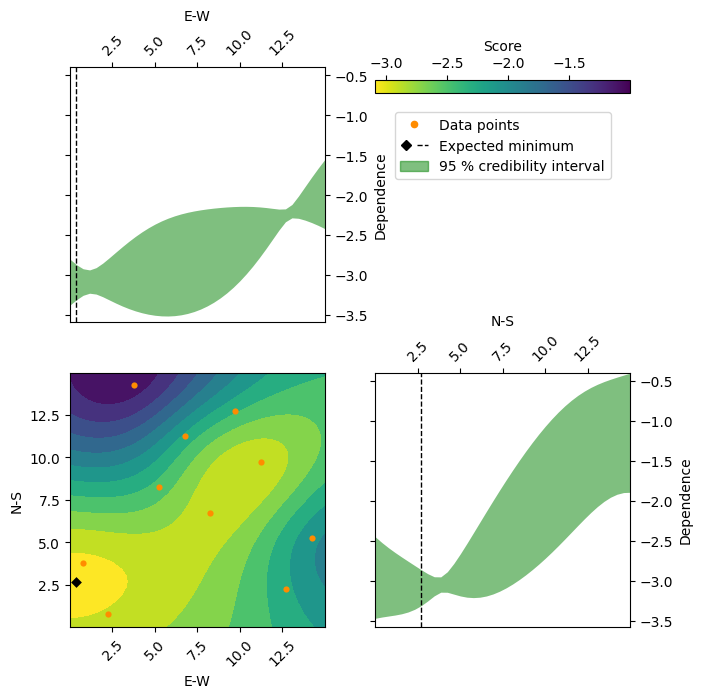

In [1]:
import numpy as np
import ProcessOptimizer
from ProcessOptimizer.model_systems import get_model_system

gold_map = get_model_system("gold_map")

coordinates = [(0.0, 15.0), (0.0, 15.0)]
opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
# For each of the first 10 positions
for index in range(10):
    # Find the place to dig
    new_dig_site = opt.ask()
    # Digging for gold
    gold_found = gold_map.get_score(new_dig_site)
    # Telling the optimiser how uch gold we found
    result = opt.tell(new_dig_site, gold_found)
# plotting
ProcessOptimizer.plot_objective(
    result=result,
    pars="expected_minimum",
    dimensions=["E-W","N-S"],
);

## One experiment at a time

Last time, we sent Ms. Dixon's team out for one dig at a time.

In [2]:
# Finding new dig site.
new_dig_site = opt.ask()
# Digging and finding gold.
gold_found = gold_map.get_score(new_dig_site)
# Telling ProcessOptimizer how much gold we found at the new dig site
opt.tell(new_dig_site,gold_found)
print(f" We found {-gold_found} mg of gold at {new_dig_site}")

 We found 3.0666375185012753 mg of gold at [0.0, 1.6473784892245629]


## Getting several suggestions at once

But after talking to Ms. Dixon, we learn that her team spends a lot of time driving back
and forth between the headquarters and the plot. So they would be much more efficient if
they could get a list of, say, 7 places to dig at at a time. Then they can go on a tour
to these 7 sites, and only then return to the headquarters to tell how much gold they
found at each dig site, and get a new list of places to dig. We can do this by setting
the `n_points` parameter of the `opt.ask()` method.

Note that we also tell the ProcessOptimizer about all seven dig sites in one call to
`tell()`. This can be done regardless of how the dig sites are found.

Going out on tour number 1
Average amount of gold found in tour 1: 2.621880719589852 mg.
Going out on tour number 2
Average amount of gold found in tour 2: 2.5790625344129494 mg.


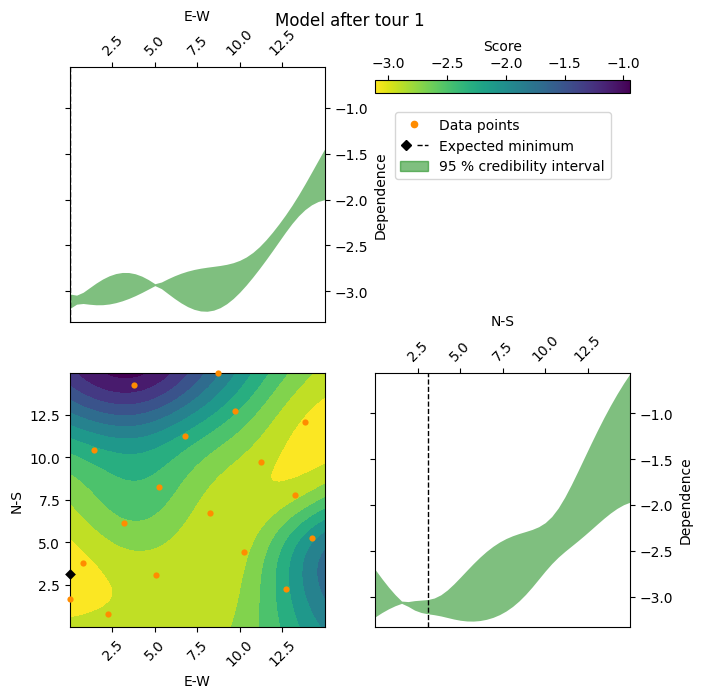

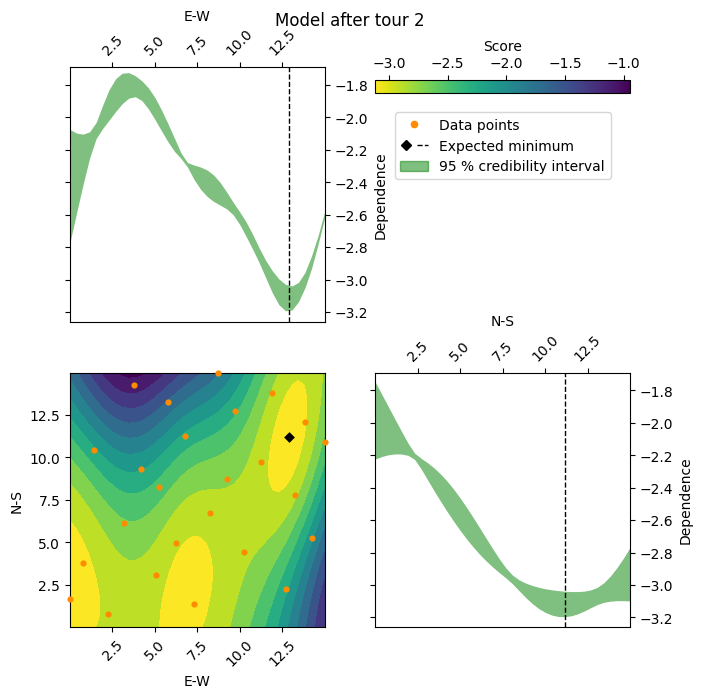

In [3]:
dig_sites_per_tour = 7
number_of_tours = 2
for tour_number in range(number_of_tours):
    print(f"Going out on tour number {tour_number+1}")
    # Finding new spots to dig at
    new_position_list = opt.ask(n_points=dig_sites_per_tour)
    # Starting the list of results of digs.
    gold_found = []
    for dig_number in range(len(new_position_list)):
        # Fishing out the next position
        dig_position = new_position_list[dig_number]
        # Digging and adding the result to the list of results of digs
        gold_found.append(gold_map.get_score(dig_position))
    print("Average amount of gold found in tour "
         f"{tour_number + 1}: {-np.mean(gold_found)} mg.")
    # Telling the ProcessOptimizer about the result of the new digs
    opt.tell(new_position_list, gold_found)
    ProcessOptimizer.plot_objective(
        result=result,
        pars="expected_minimum",
        dimensions = ["E-W","N-S"],
        title=f"Model after tour {tour_number+1}",
    )

## Knowledge gap

Notice that the average amount of gold found is lower than when we did single digs.
That is a natural consequence of us having less knowledge when planning the digs.
Before, when we planned dig 17, we had information of the amount of gold found in all
of the 16 first digs. Now, we have to plan dig 17 with only the information from the
first 10 digs.

## Strategies

There are different possible strategies to handle this lack of knowledge when being
asked for more than one new suggestion. The default strategy of ProcessOptimizer is to
use the normal approach for the first point, and try to spread the rest of the point as
far as possible in the space. It does this using Steinerberger sampling, see 
https://arxiv.org/abs/1902.03269. This was the strategy used in the previous example.

Another possibility is to "lie" to the optimizer about the amount of gold on the dig
sites it has suggested, and then ask for a new suggestion. We can either tell the
ProcessOptimizer that they have the same value as the minimum, mean or maximum of the
amounts of gold we have found at any dig site. This is done by setting the `strategy`
parameter to `"cl_min"`, `"cl_mean"`, or `"cl_max"`, respectively.

Let's try the last three strategies:

Trying strategy cl_min
Average amount of gold found with strategy cl_min on tour 1: 2.8803397088573073
Average amount of gold found with strategy cl_min on tour 2: 3.022836190471341
Trying strategy cl_mean
Average amount of gold found with strategy cl_mean on tour 1: 2.9325513878471243


c:\users\srfu\programming\processoptimizer\ProcessOptimizer\optimizer\optimizer.py:598: UserWarning: The objective has been evaluated at this point before.
  warnings.warn(


Average amount of gold found with strategy cl_mean on tour 2: 2.9014992856195057
Trying strategy cl_max
Average amount of gold found with strategy cl_max on tour 1: 2.823668541639705
Average amount of gold found with strategy cl_max on tour 2: 2.892647334208695


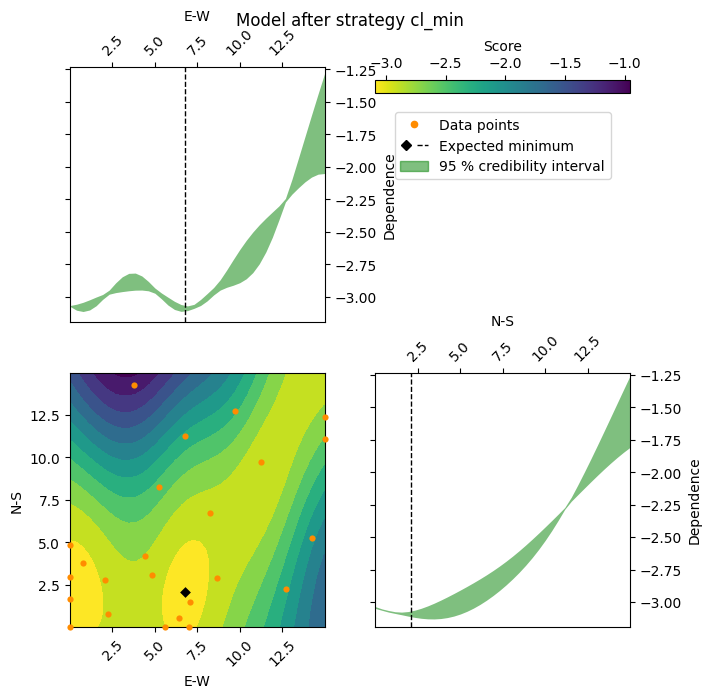

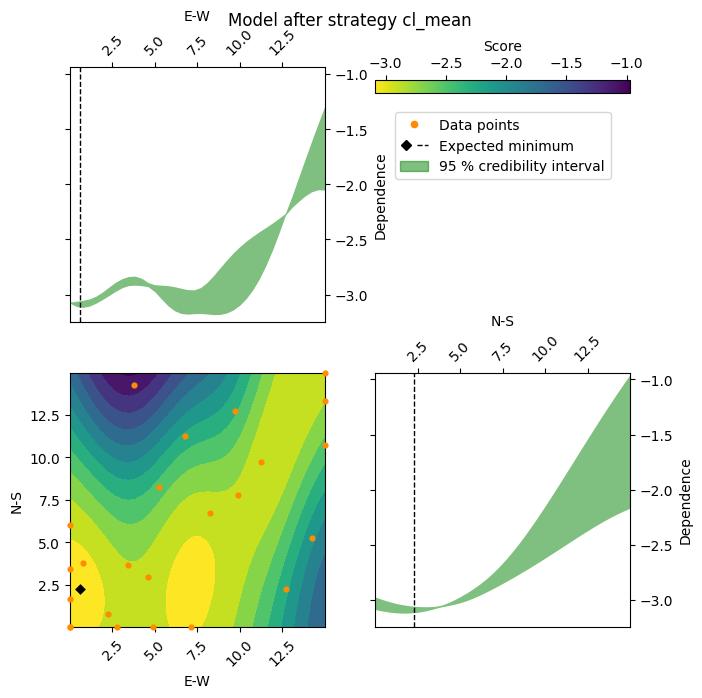

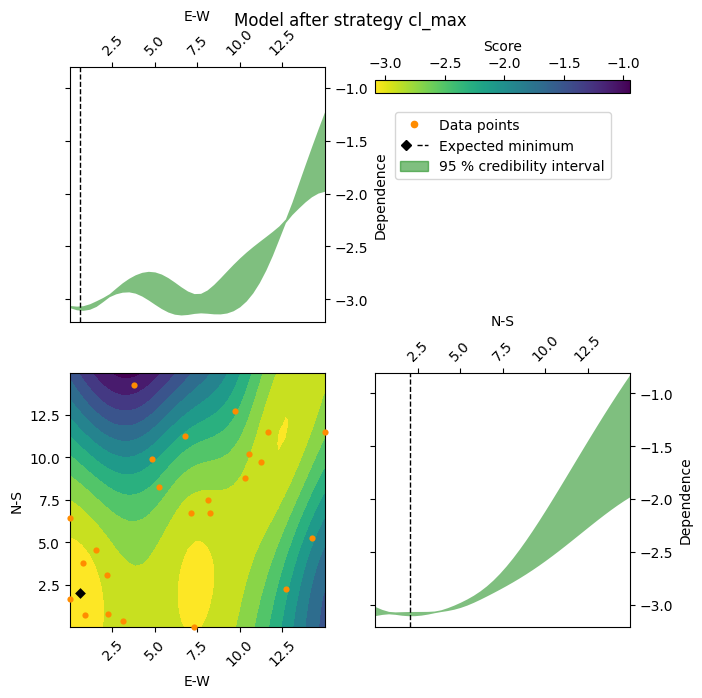

In [4]:
strategy_list = ["cl_min", "cl_mean","cl_max"]
for strategy in strategy_list:
    # Starting the optimizer
    opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
    # Telling the optimiser how much gold we found at the first 10 points
    for index in range(10):
        # Find the place to dig
        new_dig_site = opt.ask()
        # Digging for gold
        gold_found = gold_map.get_score(new_dig_site)
        # Telling the optimiser how much gold we found
        result = opt.tell(new_dig_site, gold_found)

    # Now we can use the chosen strategy.
    print(f"Trying strategy {strategy}")
    for tour_number in range(2):
        # Asking the ProcessOptimizer for new points with the chosen strategy.
        new_position_list = opt.ask(n_points = dig_sites_per_tour, strategy = strategy)
        # Starting the list of results of digs.
        gold_found = []
        for dig_number in range(len(new_position_list)):
            # Fishing out the next position
            dig_position = new_position_list[dig_number]
            # Digging and adding the result to the list of results of digs
            gold_found.append(gold_map.get_score(dig_position))
            # Telling the ProcessOptimizer about the result of the new digs
        print(f"Average amount of gold found with strategy {strategy} on tour {tour_number + 1}: {-np.mean(gold_found)}")
        opt.tell(new_position_list, gold_found)
    ProcessOptimizer.plot_objective(
        result=result,
        pars="expected_minimum",
        dimensions = ["E-W","N-S"],
        title=f"Model after strategy {strategy}",
    )

## Conclusion

Batch experiments will always be a worse strategy than doing the same number of digs one
at a time, simply due to the model having less information about the problem it is
optimizing. For a visual demonstration of this, compare the position of the digs in this
notebook to the ones in [the introduction](start_here.ipynb). The digs in this notebook
are invariably at positions with less gold.

If batch experimentation is needed, the strategy should be chosen based the type of task
at hand.